In [1]:
import networkx as nx
import pandas as pd

In [2]:
import numpy as np
from random import random

In [3]:
class Tournament(object):
    def __init__(self):
        # team Data
        self.team_dict = {}
        # Completed fixture Data
        self.fixture_list = []
        # Pending fixture Data
        self.pending_fixture_list = []
        # Default seed
        self.max_seed = 0
        # Points for a win
        self.win_pts = 3
        #Points for a draw
        self.draw_pts = 1
        #Points for a bye
        self.bye_pts = 3
        # Matchday Count
        self.matchday = 0
        # Minimum Possible Pairings
        self.min_pairings = 20
        # Tiebreaker
        self.tiebreaker = 'sonneborn-berger'
        # Whether to consider home and away
        self.home_away = True
        # Maximum number of meetings
        self.max_meetings = 1
        # Dummy variable for testing
        # self.dummy_variable = []
        # Filter Category allocation for hybrid fixtures
        self.allocation = {}
        
    
    def add_team(self, name, seed = 'none', points = 0, more = {}):
        if seed == 'none':
            seed = self.max_seed
        
        self.team_dict[name] = {'seed': seed,
                                 'points': points,
                                 'opponents': [],
                                'home_away': [],
                                'home_away_restriction': None,
                                'home_away_gap': 0,
                                 'byes': 0, 
                                'sonneborn-berger': 0}
        
        self.team_dict[name].update(more)
        
    def teams_df(self):
        df = pd.DataFrame(self.team_dict).transpose().sample(frac = 1).sort_values(by = ['points','seed'], 
                                                                                   ascending = [False,True]).reset_index(names = 'name')
        return df
    
    # Pair all teams with no extra restrictions
    def all_fixtures(self):
        self.matchday += 1
        # Update home/away restrictions
        for team in self.team_dict:
            self.home_away_restriction(team)
            
        teams_df = self.teams_df()
        self.create_fixtures(teams_df)
    
    # Pair all teams with one filter
    def filtered_fixtures(self, filter_):
        self.matchday += 1
        # Update home/away restrictions
        for team in self.team_dict:
            self.home_away_restriction(team)
            
        teams_df = self.teams_df()
        teams_divided = [teams_df[teams_df[filter_] == x].reset_index(drop=True) for x in teams_df[filter_].drop_duplicates()]
        for teams in teams_divided:
            self.create_fixtures(teams)
            
    def hybrid_fixtures(self, filter_):
        self.matchday += 1
        # Update home/away restrictions
        for team in self.team_dict:
            self.home_away_restriction(team)
            
        teams_df = self.teams_df()
        filter_categories =  teams_df[filter_].drop_duplicates()
        teams_divided = [teams_df[teams_df[filter_] == x].reset_index(drop=True) for x in filter_categories]
        
        # Sort teams into top tier and filter other teams
        top_teams = []
        other_teams = []
        for table, category in zip(teams_divided, filter_categories):
            allocation = self.allocation[category]
            top_teams.append(table[:allocation])
            other_teams.append(table[allocation:].reset_index(drop = True))
        top_tier_teams = pd.concat(top_teams).reset_index(drop = True)
        
        # Create fixtures
        self.create_fixtures(top_tier_teams)
        for teams in other_teams:
            self.create_fixtures(teams)
        
    def create_fixtures(self, teams_df):    
        # Check whether a team needs to be given a bye
        byeNeeded = (len(teams_df) % 2 == 1)
        
        # Create a network graph
        G = nx.Graph()
        
        # Parameters for creating possible pairings
        reach = max(max(teams_df.points.value_counts()), self.min_pairings, self.matchday)
        step = max(int(reach/self.min_pairings), 1)
        
        # Add edges for each pairing of teams
        for idx, data1 in teams_df.iterrows():
            team1 = data1['name']
            options = teams_df[idx + 1 : idx + reach : step]
            
            for idx2, data2 in options.iterrows():
                team2 = data2['name']
                
                ptsGap = abs(data1['points'] - data2['points'])
                seedGap = abs(data1['seed'] - data2['seed'])
                same_country = data1['country'] == data2['country']
                
                # Check home/away restrictions
                home_away_penalty = 0
                restriction1 = data1['home_away_restriction']
                restriction2 = data2['home_away_restriction']
                if (restriction1 == restriction2) & (restriction1 != None):
                    home_team1 = None
                    home_away_penalty += 1
                elif (restriction1 == 'home only') | (restriction2 == 'away only'):
                    home_team1 = team1
                elif (restriction2 == 'home only') | (restriction1 == 'away only'):
                    home_team1 = team2
                else:
                    home_team1 = None
                
                # Check Previous Matches
                previous_matches = max(data1['opponents'].count(team2) + 1 - self.max_meetings, 0)
                
                previous_matches_ha = [data1['home_away'][i] for i, x in enumerate(data1['opponents']) if x == team2]
                if previous_matches_ha.count('home') > previous_matches_ha.count('away'):
                    home_team2 = team2
                elif previous_matches_ha.count('home') < previous_matches_ha.count('away'):
                    home_team2 = team1
                else:
                    home_team2 = None
                
                home_team = None
                if (home_team1 == home_team2) | (home_team1 == None) | (home_team2 == None):
                    for home_team_decider in [home_team1, home_team2]:
                        if home_team_decider != None:
                            home_team = home_team_decider
                    if home_team == None:
                        gap = data1['home_away_gap'] - data2['home_away_gap']
                        if gap < 0:
                            home_team = team1
                        elif gap > 0:
                            home_team = team2
                else:
                    home_away_penalty += 1
                    home_team = team1
                        
                # weights are determined by number of previous matches, 
                # home/away restrictions, same country restrictions, points gap and seed gap
                weight = previous_matches * 1000 + home_away_penalty * 200 + same_country * 100 + ptsGap - seedGap/1000
                
                G.add_edge(team1, team2, weight = weight, home = home_team)
            
            # Calculate bye weights if necessary
            if byeNeeded & (len(teams_df) - idx < 101):
                pts = data1['points']
                seed = data1['seed']
                byes = data1['byes']

                weight = byes*1000 + pts - seed/1000
                G.add_edge(team1,'bye', weight = weight)
            
        # Conduct minumum weight matching
        fixtures = nx.algorithms.matching.min_weight_matching(G)
        
        # Add opponent to each team, and bye count for the team with a bye
        for fixture in fixtures:
            # Weight Check
#             weight = G[fixture[0]][fixture[1]]['weight']
#             if weight > 150:
#                 print(fixture)
#                 print(weight)
            if 'bye' in fixture:
                for team in fixture:
                    if team != 'bye':
                        self.team_dict[team]['byes'] += 1
                        self.team_dict[team]['points'] += self.bye_pts
            else:
                team1, team2 = fixture[0], fixture[1]
                self.team_dict[team1]['opponents'].append(team2)
                self.team_dict[team2]['opponents'].append(team1)
                
                # Deciding which team plays home
                if G[team1][team2]['home'] == team2:
                    final_fixture = (fixture[1], fixture[0])
                    self.team_dict[team2]['home_away'].append('home')
                    self.team_dict[team1]['home_away'].append('away')
                else:
                    final_fixture = fixture
                    self.team_dict[team1]['home_away'].append('home')
                    self.team_dict[team2]['home_away'].append('away')
                    
#                 restriction1 = self.team_dict[team1]['home_away_restriction']
#                 restriction2 = self.team_dict[team2]['home_away_restriction']
#                 swap = False
                
#                 if restriction1 == None:
#                     if restriction2 == None:
#                         gap = self.team_dict[team1]['home_away_gap'] - self.team_dict[team2]['home_away_gap']
#                         if gap > 0:
#                             swap = True
#                     elif restriction2 == 'home only':
#                         swap = True
#                 elif restriction1 == 'away only':
#                     swap = True
                
#                 if swap:
#                     final_fixture = (fixture[1], fixture[0])
#                     self.team_dict[team2]['home_away'].append('home')
#                     self.team_dict[team1]['home_away'].append('away')
#                 else:
#                     final_fixture = fixture
#                     self.team_dict[team1]['home_away'].append('home')
#                     self.team_dict[team2]['home_away'].append('away')
                
                self.pending_fixture_list.append((final_fixture[0], final_fixture[1], self.matchday))
        
    
    def report_result(self, result, more = {}):
        # Result format: {team1: score1, team2: score2}
        
        teams = list(result.keys())
        totals = list(result.values())
        
        # Remove entry in pending fixture list
        for fixture in self.pending_fixture_list:
            if (teams[0] in fixture) & (teams[1] in fixture):
                matchday = fixture[2]
                self.pending_fixture_list.remove(fixture)
        
        # Interpret result and add points
        if totals[0] > totals[1]:
            res =  teams[0]
            self.team_dict[teams[0]]['points'] += self.win_pts
        elif totals[0] == totals[1]:
            res = 'draw'
            for team in teams:
                self.team_dict[team]['points'] += self.draw_pts
        else:
            res = teams[1]
            self.team_dict[teams[1]]['points'] += self.win_pts
        
        # Store fixture result in fixture list
        result_dict = {'Home': teams[0], 
                       'score1': totals[0], 
                       'score2': totals[1], 
                       'Away': teams[1], 
                       'Result': res, 
                       'Matchday': matchday}
        result_dict.update(more)
        self.fixture_list.append(result_dict)
        
    def fixtures_df(self, team = ''):
        df = pd.DataFrame(self.fixture_list)
        if team != '':
            df = df[(df.Home == team) | (df.Away == team)]
        return df
    
    def league_table(self):
        self.sonneborn_berger()
        df = pd.DataFrame(self.team_dict).transpose()[['country','seed','sonneborn-berger','points']].sort_values(['points','sonneborn-berger','seed'], ascending = [False,False,True]).reset_index(names = 'team')
        return df
    
    def filtered_league_tables(self, filter_ = 'country'):
        df = self.league_table()
        filter_categories = df[filter_].drop_duplicates()
        
        tables_dict = {}
        for cat in filter_categories:
            tables_dict[cat] = df[df[filter_] == cat].reset_index(drop=True)
        
        return tables_dict
    
    def sonneborn_berger(self):
        for team in self.team_dict:
            tiebreaker = 0
            fixture_df = self.fixtures_df()
            results = fixture_df[(fixture_df.Home == team) | (fixture_df.Away == team)].reset_index(drop = True).Result
            opponents = self.team_dict[team]['opponents']

            for opponent, result in zip(opponents, results):
                opp_points = self.team_dict[opponent]['points']

                if result == team:
                    tiebreaker += self.win_pts * opp_points
                elif result == 'draw':
                    tiebreaker += self.draw_pts * opp_points
            
            self.team_dict[team]['sonneborn-berger'] = tiebreaker
            
    def home_away_restriction(self, team):
        data = self.team_dict[team]
        home_away_list = data['home_away']
        home_away_gap = home_away_list.count('home') - home_away_list.count('away')
        self.team_dict[team]['home_away_gap'] = home_away_gap
        restriction = None
        
        # Checks for previous 2 and 4 matches
        for check in ['home','away']:
            last2_check = (home_away_list[-2:].count(check) == 0) & (len(home_away_list) > 1)
            last4_check = (home_away_list[-4:].count(check) <= 1) & (len(home_away_list) > 3)
            if last2_check | last4_check:
                restriction = check + ' only'
#                 print(team, restriction)
        
        if restriction == None:
            # Check for overall home and away matches
            if home_away_gap == -2:
                restriction = 'home only'
            elif home_away_gap == 2:
                restriction = 'away only'
            else:
                restriction = None

        self.team_dict[team]['home_away_restriction'] = restriction

In [4]:
mymodel = np.poly1d([-0.63338287,  0.4410632 ,  0.08619369,  0.16459536])

In [5]:
def sim_fixtures(tournament):
    results = []
    for fixture in tournament.pending_fixture_list:
        team1, team2 = fixture[0], fixture[1]
        data1, data2 = tournament.team_dict[team1], tournament.team_dict[team2]
        elo1, elo2 = data1['elo'], data2['elo']

        score = sim_match(elo1, elo2)

        results.append({team1: score[0], team2: score[1]})
    return results

In [6]:
def sim_match(elo1, elo2, home_coef = 1.25):
    m = elo1 - elo2
    prob = 1/(1+10**(-m/400))
    
    if home_coef != 1:
        odds = prob/(1-prob)
        new_odds = odds * home_coef
        new_prob = new_odds / (1+new_odds)
    
    draw_prob = mymodel(new_prob)
    win_prob = prob/(1-draw_prob)

    result = random()

    if win_prob - result > 0.00001:
        score = [1, 0]
    elif win_prob + draw_prob - result > 0.00001:
        score = [0.5, 0.5]
    else:
        score = [0, 1]
    
    return score

In [62]:
teams_data = pd.read_csv('teams_data2.csv')
teams_data[:50]

,Club,Elo,Country
0,Manchester City,2386,ENG
1,Real Madrid,2335,ESP
2,Inter,2314,ITA
3,Liverpool FC,2266,ENG
4,Arsenal FC,2232,ENG
5,Bayer Leverkusen,2222,DEU
6,Bayern München,2221,DEU
7,Paris Saint-Germain,2216,FRA
8,Atlético Madrid,2187,ESP
9,Borussia Dortmund,2159,DEU


In [51]:
country_data = pd.read_csv('country_data.csv', index_col = 0)
country_data

,Elo,Teams,Allocation
ENG,2144.6,125,10
ESP,2095.0,66,10
ITA,2081.9,45,10
DEU,2055.6,168,10
FRA,2003.5,77,10
PRT,1890.7,56,6
BEL,1859.4,43,6
NLD,1844.7,64,6
CZE,1814.8,40,6
TUR,1807.1,47,6


In [95]:
to = Tournament()

In [96]:
for idx, row in teams_data.iterrows():
    team = row.Club
    elo = row.Elo
    country = row.Country
    seed = idx + 1
    
    to.add_team(team, seed, more = {'elo': elo, 'country': country})

In [97]:
to.allocation = country_data.Allocation.to_dict()

In [98]:
# Tournament simulator
season_length = 40

for n in range(to.matchday + 1, season_length + 1):
    if n % 2 == 0:
        to.hybrid_fixtures('country')
        if n % 20 == 0:
            to.max_meetings += 1
    else:
        teams_divided = to.filtered_fixtures('country')

    results = sim_fixtures(to)

    for result in results:
        to.report_result(result)
    
    print('Fixture ', n)

Fixture  1
Fixture  2
Fixture  3
Fixture  4
Fixture  5
Fixture  6
Fixture  7
Fixture  8
Fixture  9
Fixture  10
Fixture  11
Fixture  12
Fixture  13
Fixture  14
Fixture  15
Fixture  16
Fixture  17
Fixture  18
Fixture  19
Fixture  20
Fixture  21
Fixture  22
Fixture  23
Fixture  24
Fixture  25
Fixture  26
Fixture  27
Fixture  28
Fixture  29
Fixture  30
Fixture  31
Fixture  32
Fixture  33
Fixture  34
Fixture  35
Fixture  36
Fixture  37
Fixture  38
Fixture  39
Fixture  40


In [99]:
to.matchday

40

In [100]:
league_table = to.league_table()

In [113]:
league_table = pd.DataFrame(to.team_dict).transpose()[['country','seed','sonneborn-berger','points']].sort_values(['points','sonneborn-berger','seed'], ascending = [False,False,True]).reset_index(names = 'team')

In [115]:
league_table[league_table.country == 'ENG']

,team,country,seed,sonneborn-berger,points
0,Manchester City,ENG,1,7344,96
3,Arsenal FC,ENG,5,6870,92
39,Liverpool FC,ENG,4,6159,83
111,Chelsea FC,ENG,29,5565,78
113,Tottenham Hotspur,ENG,24,5497,78
...,...,...,...,...,...
1629,Yeovil Town,ENG,1649,1543,41
1716,Kings Lynn,ENG,1671,1351,36
1717,Chester FC,ENG,1697,1343,36
1779,Weymouth FC,ENG,1739,1229,30


In [302]:
league_tables = to.filtered_league_tables()

In [85]:
for team in to.team_dict:
    for n in range(5):
        for check in ['home','away']:
            if to.team_dict[team]['home_away'][n:n+3].count(check) == 3:
                print(team)
                print(to.team_dict[team]['home_away'])
    

In [117]:
to.fixtures_df('Manchester United')

,Home,score1,score2,Away,Result,Matchday
10,Manchester United,1.0,0.0,Torquay United,Manchester United,1
911,Manchester United,1.0,0.0,FK Panevežys,Manchester United,2
1798,Rotherham United,0.0,1.0,Manchester United,Manchester United,3
2775,KR Reykjavík,0.0,1.0,Manchester United,Manchester United,4
3701,Manchester United,1.0,0.0,Ipswich Town,Manchester United,5
4540,Manchester United,0.5,0.5,Lille OSC,draw,6
5456,Chelsea FC,1.0,0.0,Manchester United,Chelsea FC,7
6314,Manchester United,1.0,0.0,Getafe CF,Manchester United,8
7228,AFC Bournemouth,1.0,0.0,Manchester United,AFC Bournemouth,9
8195,Manchester United,1.0,0.0,Hull City,Manchester United,10


In [118]:
deltas = []

for idx, row in league_table.iterrows():
    team = row.name
    position = idx + 1
    seed = row.seed
    delta = position - seed
    deltas.append(delta)
    
league_table['position-seed delta'] = deltas 

In [119]:
league_table[:50]

,team,country,seed,sonneborn-berger,points,position-seed delta
0,Manchester City,ENG,1,7344,96,0
1,Inter,ITA,3,7074,95,-1
2,Paris Saint-Germain,FRA,8,7026,95,-5
3,Arsenal FC,ENG,5,6870,92,-1
4,Bayern München,DEU,7,6987,91,-2
5,Atlético Madrid,ESP,9,6810,90,-3
6,Galatasaray,TUR,34,6498,90,-27
7,Slavia Praha,CZE,31,6240,89,-23
8,Real Madrid,ESP,2,6798,88,7
9,PSV Eindhoven,NLD,11,6412,88,-1


In [120]:
# Examining the relationship between league winning margin and average position-seed delta
league_tables = to.filtered_league_tables()

winning_margin_dict = {}
for country in league_tables:
    table = league_tables[country]
    if len(table) > 1:
        delta = table['points'][0] - table['points'][1]
        winning_margin_dict[country] = delta
    
df = league_table.groupby('country').mean()
margins = []
for idx, row in df.iterrows():
    try:
        margins.append(winning_margin_dict[idx])
    except:
        margins.append(None)

df['margins'] = margins

df.dropna(how = 'any').plot(x = 'margins', y = 'position-seed delta',  kind = 'scatter')

NameError: name 'league_tables' is not defined

In [121]:
df.sort_values(by = 'margins', ascending = False)

NameError: name 'df' is not defined

C:\Users\Usamah\AppData\Local\Temp\ipykernel_12976\3719136059.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  league_table.groupby('country').mean().sort_values(by = 'position-seed delta').plot.bar(figsize = (10,5))


<Axes: xlabel='country'>

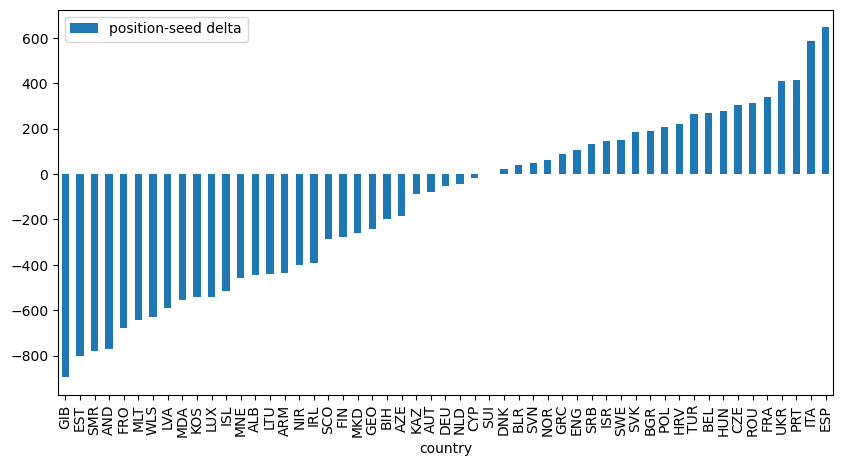

In [122]:
league_table.groupby('country').mean().sort_values(by = 'position-seed delta').plot.bar(figsize = (10,5))

<Axes: xlabel='country'>

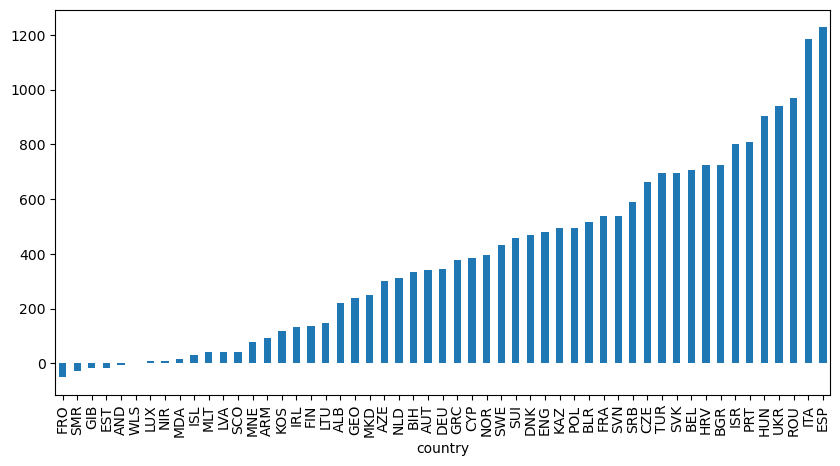

In [131]:
league_table.groupby('country')['position-seed delta'].max().sort_values().plot.bar(figsize = (10,5))

In [340]:
league_table[league_table.byes > 1].sort_values('byes', ascending = False)[['name','points','country','byes']]

,name,points,country,byes
51,Vaduz,72,LIE,20
576,Sutjeska,44,MNT,7
627,Cosmos,36,SMR,7
620,College Europa,38,GIB,7
619,Atletic Club Escaldes,38,AND,7
614,La Fiorita,39,SMR,7
578,Escaldes,44,AND,7
327,Breiðablik,56,ISL,7
630,FCB Magpies,30,GIB,7
534,Podgorica,47,MNT,7


<Axes: >

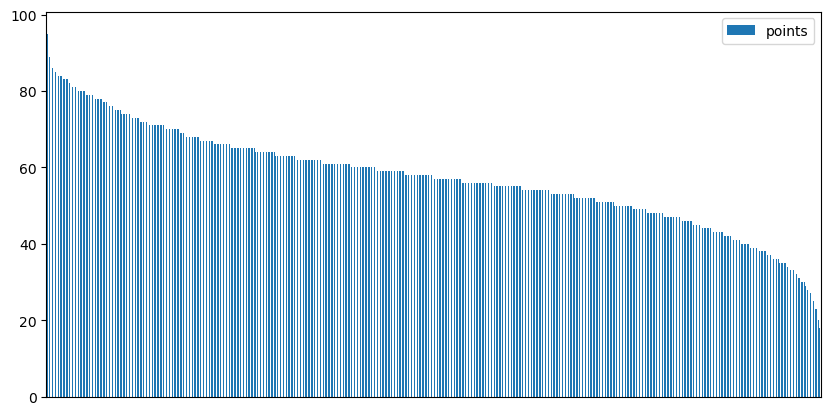

In [134]:
league_table.plot.bar(y = 'points', xticks = [], figsize = (10,5))

<Axes: ylabel='Frequency'>

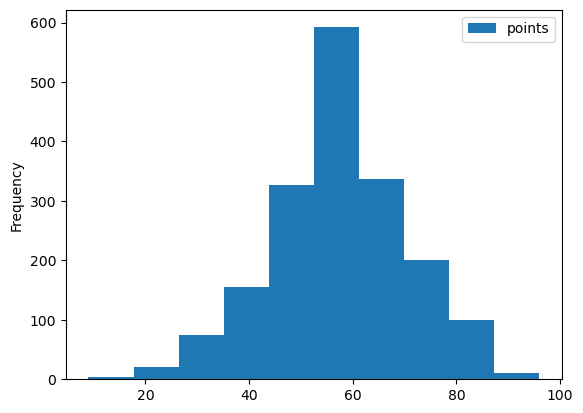

In [132]:
league_table.plot.hist(y = 'points')

<Axes: xlabel='country'>

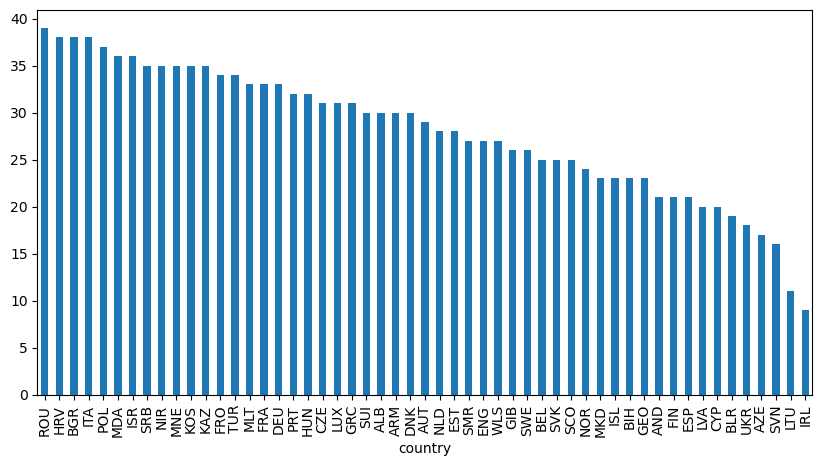

In [149]:
league_table.groupby('country')['points'].min().sort_values(ascending = False).plot.bar(figsize = (10,5))

In [151]:
league_table.drop_duplicates('country')

,team,country,seed,sonneborn-berger,points,position-seed delta
0,Manchester City,ENG,1,7344,96,0
1,Inter,ITA,3,7074,95,-1
2,Paris Saint-Germain,FRA,8,7026,95,-5
4,Bayern München,DEU,7,6987,91,-2
5,Atlético Madrid,ESP,9,6810,90,-3
6,Galatasaray,TUR,34,6498,90,-27
7,Slavia Praha,CZE,31,6240,89,-23
9,PSV Eindhoven,NLD,11,6412,88,-1
10,FC Porto,PRT,16,6488,87,-5
11,RB Salzburg,AUT,45,6266,87,-33


In [152]:
import pickle

with open ('TournamentV5_sample.pickle','wb') as file:
    pickle.dump(to, file)

In [280]:
False == 0

True

In [153]:
fixtures = to.fixtures_df()

upset_list = []

for idx, row in fixtures.iterrows():
    teams, result = [row.Home, row.Away], row.Result
    seeds = [to.team_dict[x]['seed'] for x in teams]
    
    home_advantage = seeds[0] < seeds[1]
    home_result = result == teams[0]
    
    if result == 'draw':
        text = 'draw'
    else:
        if home_advantage == home_result:
            text = 'hold'
        else:
            text = 'upset'
    upset_list.append(text)

In [155]:
fixtures

,Home,score1,score2,Away,Result,Matchday,upset?
0,Leeds United,1.0,0.0,Fleetwood Town,Leeds United,1,hold
1,Southend United,0.0,1.0,Hull City,Hull City,1,hold
2,AFC Fylde,0.0,1.0,Cardiff City,Cardiff City,1,hold
3,Alfreton Town,0.5,0.5,Leyton Orient,draw,1,draw
4,Portsmouth FC,1.0,0.0,Salford City,Portsmouth FC,1,hold
...,...,...,...,...,...,...,...
35915,FC Fiorentino,0.5,0.5,AC Libertas,draw,40,draw
35916,SP Tre Penne,1.0,0.0,SS San Giovanni,SP Tre Penne,40,hold
35917,SC Faetano,0.0,1.0,SS Folgore/Falciano,SS Folgore/Falciano,40,hold
35918,FC Domagnano,0.0,1.0,SS Cosmos,SS Cosmos,40,hold


In [156]:
fixtures['upset?'] = upset_list

rate_list = []
for n in range(1, 41):
    mask = fixtures['Matchday'] == n
    result_rates = fixtures[mask].value_counts(subset = 'upset?')/sum(mask)
    rate_list.append(result_rates)

<Axes: >

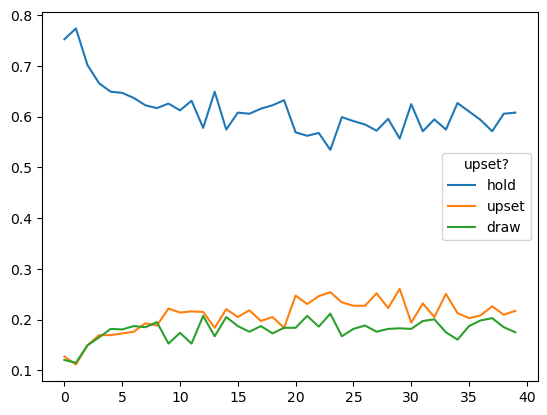

In [157]:
pd.DataFrame(rate_list).plot()

In [159]:
to.fixtures_df('Inter')

,Home,score1,score2,Away,Result,Matchday
105,Inter,1.0,0.0,SPAL 2013 Ferrara,Inter,1
930,Inter,1.0,0.0,NK Radomlje,Inter,2
1896,US Salernitana 1919,0.0,1.0,Inter,Inter,3
2800,St. Mirren FC,0.0,1.0,Inter,Inter,4
3639,Inter,1.0,0.0,Sassuolo Calcio,Inter,5
4509,Inter,1.0,0.0,FC Twente,Inter,6
5428,ACF Fiorentina,1.0,0.0,Inter,ACF Fiorentina,7
6347,Inter,1.0,0.0,1. FC Union Berlin,Inter,8
7523,Hellas Verona,0.5,0.5,Inter,draw,9
8167,Inter,1.0,0.0,Shakhtar Donetsk,Inter,10


In [161]:
league_table.head(10)

,team,country,seed,sonneborn-berger,points,position-seed delta
0,Manchester City,ENG,1,7344,96,0
1,Inter,ITA,3,7074,95,-1
2,Paris Saint-Germain,FRA,8,7026,95,-5
3,Arsenal FC,ENG,5,6870,92,-1
4,Bayern München,DEU,7,6987,91,-2
5,Atlético Madrid,ESP,9,6810,90,-3
6,Galatasaray,TUR,34,6498,90,-27
7,Slavia Praha,CZE,31,6240,89,-23
8,Real Madrid,ESP,2,6798,88,7
9,PSV Eindhoven,NLD,11,6412,88,-1


In [23]:
list_ = ['Home','Away']
restriction = list_[0] + ' Only'
restriction

'Home Only'

In [24]:
True * 1000

1000

In [96]:
None != None

False

In [36]:
G = nx.Graph()

In [37]:
G.add_edge(1, 2, weight = 0, home = '1')

In [41]:
True | False

True